# plot_transition.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 10 April 2023

Purpose: Plot timeseries normalized by large eddy turnover time and instantaneous cross-sections of w and Rww

In [7]:
import sys
sys.path.append("/home/rfrost/LES-utils/")

import seaborn
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESutils import load_full
import seaborn

Settings

In [8]:
# location of netCDF simulation output
output = "/home/rfrost/sim_output/abl_transition/"
# name of simulation
sim = "step_change_3"
# ug of simulation in m/s
ug = 9
# heights being analyzed
heights = np.array([0.25])
# timesteps
t0 = 576000
t1 = 720000
dnc = f"{output}{sim}/"
# start/end times in hours
t0hr = t0 * 0.05 / 3600
t1hr = t1 * 0.05 / 3600
# flag to normalize time by TL
norm_time = False

### Read in data

In [9]:
# volumetric stats
stats = xr.open_dataset(f"{dnc}{t0}_{t1}_stats.nc")
# find which timestep t0 occurs
jt = abs(stats.time.values - 0).argmin()
# calculate large eddy turnover time
TL = stats.zi.isel(time=jt) / stats.wstar.isel(time=jt)
TL = TL / 3600
# convert time to hours
stats["time"] = stats.time / 3600 + t0hr
stats = stats.where(stats.time >= 8, drop=True)
stats = stats.where(stats.time <= 15, drop=True)
# center time around forcing change
stats["time"] = stats.time# - 10

# roll factor
R = []
h = heights * 100
h = h.astype(int)
for i in h:
    r = xr.load_dataarray(f"{dnc}rollfactor_zzi{i}_raw.nc")
    R.append(r)
# convert time to hours and center around surface forcing change
for i, r in enumerate(R):
    r["time"] = (r.time) / 3600 + t0hr# - 10

# autocorrelation
R2d = xr.open_dataset(f"{dnc}R_2d.nc")
# convert time to hours and center around surface forcing change
R2d["time"] = R2d.time / 3600 + t0hr# - 10

# normalize time by TL if desired
if norm_time:
    # stats
    stats["time"] = stats.time / TL
    # roll factor
    for i, r in enumerate(R):
        r["time"] = r.time / TL
    # 2d autocorr
    R2d["time"] = R2d.time / TL

### Timeseries plots

In [10]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')
cmap = seaborn.color_palette("Spectral", as_cmap=True)
colors = seaborn.color_palette("rocket_r", len(heights))

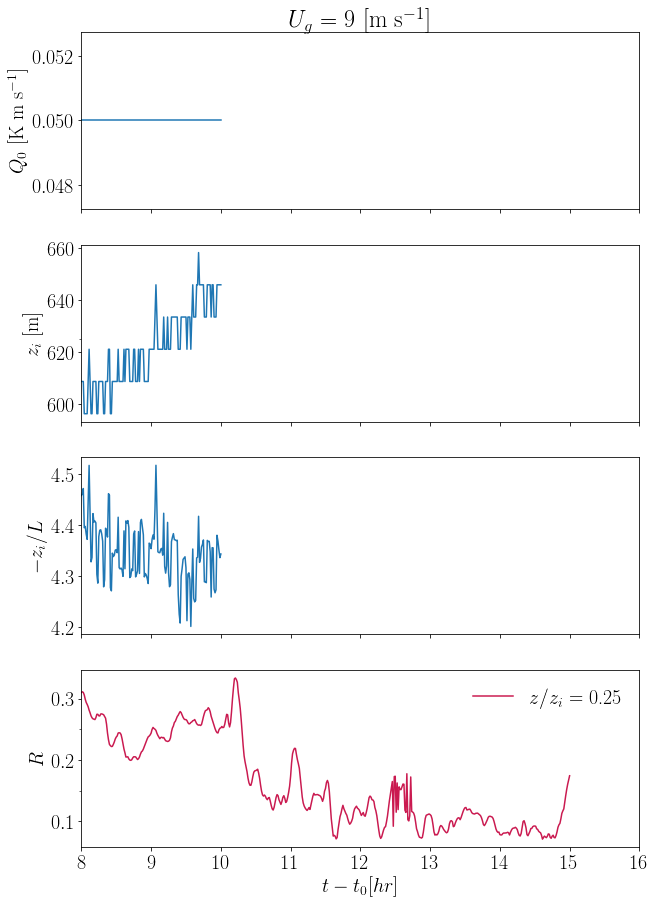

In [11]:
fig, ax = plt.subplots(figsize=(10,15), nrows=5, sharex=True)

# Q0
ax[0].plot(stats.time, stats.tw_cov_tot.isel(z=0))
# zi
ax[1].plot(stats.time, stats.zi)
# -zi/L
ax[2].plot(stats.time, stats.zi_L)
for i, r in enumerate(R):
    # R
    ax[3].plot(r.time, r, c=colors[i], label=f"$z/z_i$ = {heights[i]}")

# clean up
ax[0].set_ylabel("$Q_0$ [K m s$^{-1}$]")
ax[1].set_ylabel("$z_i$ [m]")
ax[2].set_ylabel("$-z_i / L$")
ax[3].set_ylabel("$R$")
ax[3].set_xlabel("$t - t_0 [hr]$")
ax[3].legend(frameon=False)
ax[3].set_xlim(8,16)

# add vertical line at t0
for iax in ax:
    iax.axvline(x=0, ls="--", c="black", alpha=0.5, lw=1.25)
    # minor ticks on x axis
    iax.xaxis.set_minor_locator(MultipleLocator(1))

# add minor ticks to y axis
ax[0].yaxis.set_minor_locator(MultipleLocator(0.025))
ax[1].yaxis.set_minor_locator(MultipleLocator(125))
ax[2].yaxis.set_minor_locator(MultipleLocator(5))
ax[3].yaxis.set_minor_locator(MultipleLocator(0.05))

fig.tight_layout
ax[0].set_title(f"$U_g$ = {ug} [m s$^{{-1}}$]")
plt.show()
plt.close(fig)

In [12]:
stats

<xarray.Dataset>
Dimensions:     (time: 145, z: 160)
Coordinates:
  * z           (z) float64 12.5 24.92 37.34 ... 1.963e+03 1.975e+03 1.988e+03
  * time        (time) float64 8.0 8.014 8.028 8.042 ... 9.958 9.972 9.986 10.0
Data variables:
    u_mean      (time, z) float64 5.247 6.181 6.445 6.664 ... 9.001 9.007 9.011
    v_mean      (time, z) float64 2.74 3.181 3.293 ... 0.02523 0.02138 0.01808
    w_mean      (time, z) float64 0.0 3.451e-18 ... 1.852e-17 -9.089e-18
    theta_mean  (time, z) float64 303.7 303.6 303.5 303.5 ... 312.2 312.2 312.2
    uw_cov_res  (time, z) float64 0.0 -0.1114 -0.1238 ... 2.191e-05 1.064e-05
    uw_cov_tot  (time, z) float64 -0.1757 -0.1615 ... 1.315e-05 5.405e-06
    vw_cov_res  (time, z) float64 0.0 -0.05518 -0.05868 ... 6.4e-05 2.693e-05
    vw_cov_tot  (time, z) float64 -0.09167 -0.08096 ... 6.996e-05 3.039e-05
    tw_cov_res  (time, z) float64 0.0 0.02833 0.0346 ... 1.728e-08 3.165e-06
    tw_cov_tot  (time, z) float64 0.05 0.04455 0.04069 ... -6.607e-05 -3.346e-05
    uu_var      (time, z) float64 1.196 1.141 0.9405 ... 0.05187 0.05218 0.05241
    vv_var      (time, z) float64 1.245 1.151 0.9635 ... 0.02448 0.0245 0.02471
    ww_var      (time, z) float64 0.0 0.1025 0.1973 ... 0.0002865 7.766e-05
    tt_var      (time, z) float64 0.05312 0.03966 ... 5.717e-05 2.834e-05
    ustar       (time, z) float64 0.4451 0.425 0.3947 ... 0.008437 0.005555
    ustar0      (time) float64 0.4451 0.445 0.4447 ... 0.4574 0.4579 0.4576
    zi          (time) float64 608.7 608.7 608.7 596.3 ... 646.0 646.0 646.0
    L           (time) float64 -136.5 -136.4 -136.1 ... -148.5 -149.0 -148.7
    zi_L        (time) float64 4.459 4.462 4.472 4.395 ... 4.351 4.336 4.343
    wstar       (time) float64 0.9943 0.9943 0.9943 0.9875 ... 1.013 1.013 1.013
    u_var       (time, z) float64 1.196 1.141 0.9405 ... 0.05187 0.05218 0.05241
    v_var       (time, z) float64 1.245 1.151 0.9635 ... 0.02448 0.0245 0.02471
    w_var       (time, z) float64 0.0 0.1024 0.1973 ... 0.0002865 7.766e-05
    alpha       (time, z) float64 0.4812 0.4753 0.4723 ... 0.002373 0.002006
    u_mean_rot  (time, z) float64 5.919 6.952 7.238 7.478 ... 9.001 9.007 9.011
    v_mean_rot  (time, z) float64 4.441e-16 0.0 0.0 0.0 ... 0.0 -3.469e-18 0.0
    u_var_rot   (time, z) float64 1.28 1.21 0.966 ... 0.05178 0.0521 0.05234
    v_var_rot   (time, z) float64 1.161 1.082 0.938 ... 0.02458 0.02458 0.02477
Attributes:
    nx:       160
    ny:       160
    nz:       160
    Lx:       12000.0
    Ly:       12000.0
    Lz:       2000.0
    dx:       75.0
    dy:       75.0
    dz:       12.5
    delta:    41.27409061118283

Roll factor

Text(0.5, 0, '$(t - t_0) / T_L$')

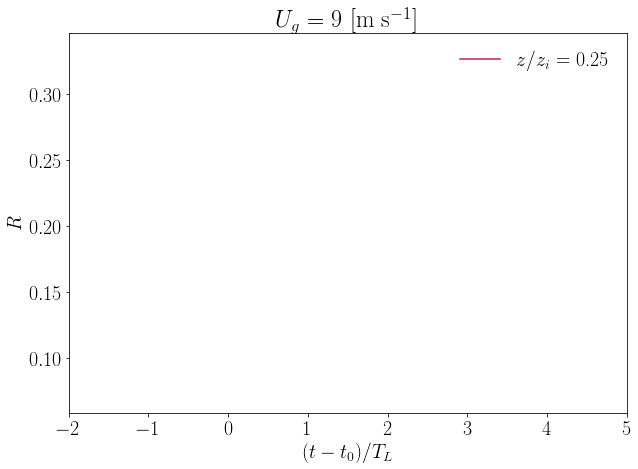

In [13]:
fig, ax = plt.subplots(figsize=(10,7))

for i, r in enumerate(R):
    # R
    ax.plot(r.time, r, c=colors[i], label=f"$z/z_i$ = {heights[i]}")

ax.set_xlim(-2,5)
ax.legend(frameon=False)
ax.set_title("$U_g$ = 9 [m s$^{-1}$]")
ax.set_ylabel("$R$")
ax.set_xlabel("$(t - t_0) / T_L$")

### Cross sections

$w'$

In [14]:
timesteps = np.arange(t0, t1+1, 1000, dtype=np.int32)
t = (0.05 * timesteps) / 3600. # convert timesteps to hours
# grab the timesteps for loading
# array of times
tload = np.array([8, 8.5, 9, 9.5, 10, 10.5]) # hrs
# loop to find nearest timestep
jt1 = np.array([np.argmin(np.abs(t - tt)) for tt in tload])
# number of timesteps
nt = len(tload)
df_all = []
# read in sim output
for jt in jt1:
    f = f"{dnc}all_{timesteps[jt]:07d}.nc"
    # load mf dataset
    df = xr.open_mfdataset(f, combine="nested", concat_dim="time")
    # df.coords["time"] = t[jt1]
    # df.time.attrs["units"] = "hr"
    df_all.append(df)

In [15]:
for jt, df in enumerate(df_all):
    for v in ["u", "v", "w", "theta"]:
        df[f"{v}_mean"] = df[v].mean(dim=("x", "y"))
        df[f"{v}_pert"] = df[v] - df[f"{v}_mean"]
    # covars
    df["uw"] = (df.u - df.u_mean) * (df.w - df.w_mean) + df.txz
    df["vw"] = (df.v - df.v_mean) * (df.w - df.w_mean) + df.tyz
    df["tw"] = (df.theta - df.theta_mean) * (df.w - df.w_mean) + df.q3
    # vars
    df["uu"] = (df.u - df.u_mean) * (df.u - df.u_mean)
    df["vv"] = (df.v - df.v_mean) * (df.v - df.v_mean)
    df["ww"] = (df.w - df.w_mean) * (df.w - df.w_mean)
    df["tt"] = (df.theta - df.theta_mean) * (df.theta - df.theta_mean)

    # calculate averages
    df["uw_cov_tot"] = df.uw.mean(dim=("x","y"))
    df["vw_cov_tot"] = df.vw.mean(dim=("x","y"))
    df["tw_cov_tot"] = df.tw.mean(dim=("x","y"))
    df["uu_var"] = df.uu.mean(dim=("x","y"))
    df["vv_var"] = df.vv.mean(dim=("x","y"))
    df["ww_var"] = df.ww.mean(dim=("x","y"))
    df["tt_var"] = df.tt.mean(dim=("x","y"))

    # calculate ustar
    df["ustar"] = ((df.uw_cov_tot**2) + (df.vw_cov_tot**2))**0.25
    df["ustar0"] = df.ustar.isel(z=0)
    df["ustar2"] = ((df.uw_cov_tot**2) + (df.vw_cov_tot**2.)) ** 0.5

    # calulcate z_i
    idx = df.tw_cov_tot.argmin(axis=1)
    df["zi"] = df.z[idx]

    # calulate obukhov length
    df["theta_mean"] = df.theta.mean(dim=("x","y"))
    df["L"] = -1*(df.ustar0**3) * df.theta_mean.isel(z=0) / (.4 * 9.81 * df.tw_cov_tot.isel(z=0))
    # calculate -zi/L
    df["zi_L"] = -1*(df.zi / df.L)

    # calculate wstar
    df["wstar"] = ((9.81/df.theta_mean.isel(z=0)) * df.tw_cov_tot.isel(z=0)*df.zi)**(1/3)

    # calculate TKE
    df["tke"] = (1/2) * (df.uu + df.vv + df.ww)

IndexError: Index is not smaller than dimension 1 >= 1

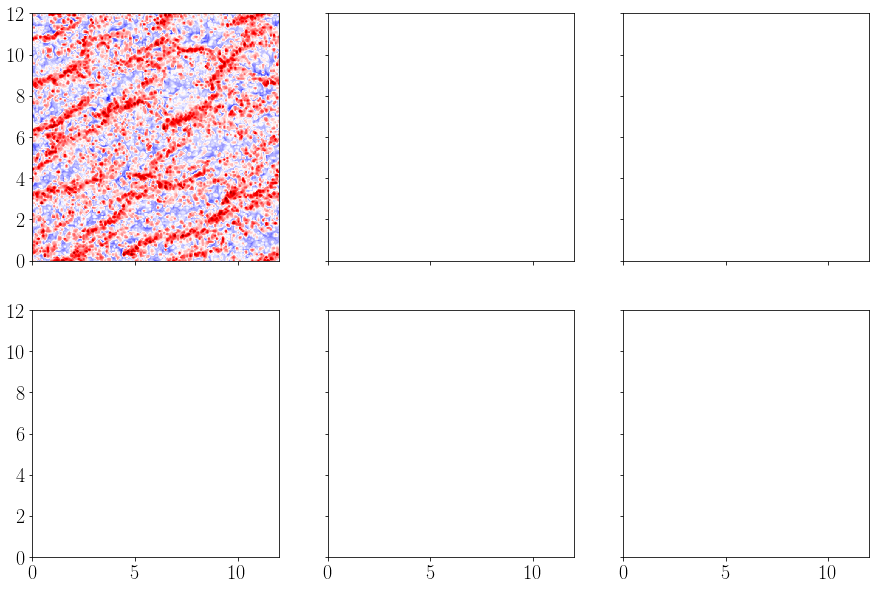

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,10))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
levelw = np.linspace(-2.5, 2.5, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax.flatten()):
    # calc z/zi
    jzi = stats.tw_cov_tot.isel(time=jt).argmin().values
    zzi = stats.z/stats.z[jzi]
    jz = abs(zzi - heights[0]).argmin()
    # contour
    cfax = iax.contourf(df.x/1000, df.y/1000, df.w_pert.isel(time=jt, z=jz).T / df.wstar.isel(time=jt),
                        levels=levelw, cmap=mpl.cm.seismic, extend="both")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig4.colorbar(cfax1[0], ax=ax[:,-1], location="right", ticks=MultipleLocator(2))
# cb label
cb.ax.set_ylabel(f"$ w' / w_*  (z/z_i={h})$")# [m s$^{{{-1}}}$]")
# axis limits
ax[0,0].set_xlim(0, 12)
ax[0,0].set_ylim(0, 12)
# axis ticks
ax[0,0].xaxis.set_major_locator(MultipleLocator(4))
ax[0,0].yaxis.set_major_locator(MultipleLocator(4))
# axis labels
for iax in ax[:,0]:
    iax.set_ylabel("$y$ [km]")
for iax in ax[1,:]:
    iax.set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax.flatten(), list("abcdef"))):
        iax.set_title(f"({lab}) $t =$ {df_all[sim].time[jt].values.round(2)} hr, $R$ = {R_list[jt].round(3)}, $-z_i / L$ = {df_all[sim].zi_L.isel(time=jt).values.round(2)}", fontsize=16, loc="left")
# plot title
fig4.suptitle("$U_g$ = 15 m s$^{-1}$")
# plt.suptitle(f"$U_g$ = {ug[sim]} [m s$^{{{-1}}}$]")
# save figure
# fsave = f"{figdir}agu1_w_zzi_6panel.png"
# fig1.savefig(fsave, dpi=900)
plt.show(fig)
plt.close(fig)